# Predict stock prices  with Long short-term memory (LSTM)

This simple example will show you how LSTM models predict time series data. Stock market data is a great choice for this because it's quite regular and widely available via the Internet. 

## Install requirements
We install Tensorflow 2.0 with GPU support first

In [1]:
!pip install tensorflow-gpu==2.0.0

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0 (from versions: 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.0.0


In [2]:
!pip install pandas-datareader

In [76]:
!apt install graphviz

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [4]:
!pip install pydot pydot-ng

## Introduction

LSTMs are very powerful in sequence prediction problems. They can store past information.

## Loading the dataset
I use pandas-datareader to get the historical stock prices from Yahoo! finance. For this example, I get only the historical data till the end of *training_end_data*.  

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.0.0)/charset_normalizer (2.0.10) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [6]:
!pwd
tickers = 'AAPL'

start_date = '2014-01-01'
end_date = '2015-12-31'

stock_data = pd.read_csv(r'AAPL.csv')

/home/studio-lab-user/sagemaker-studiolab-notebooks/notebooks/transformers_doc/MyNotebooks/Untitled Folder/Stocknet


In [7]:
stock_data.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-09-04,95.108574,96.448570,94.928574,96.424286,87.121140,91973000
1,2012-09-05,96.510002,96.621429,95.657143,95.747147,86.509338,84093800
2,2012-09-06,96.167145,96.898575,95.828575,96.610001,87.288956,97799100
3,2012-09-07,96.864288,97.497147,96.538574,97.205711,87.827171,82416600
4,2012-09-10,97.207146,97.612854,94.585716,94.677139,85.542564,121999500
5,2012-09-11,95.015717,95.728569,93.785713,94.370003,85.265068,125995800
6,2012-09-12,95.264282,95.699997,93.714287,95.684288,86.452538,178058300
7,2012-09-13,96.767143,97.928574,96.395714,97.568573,88.155037,149590000
8,2012-09-14,98.565712,99.568573,98.269997,98.754288,89.226341,150118500
9,2012-09-17,99.907143,99.971428,99.230003,99.968575,90.323479,99507800


In [8]:
stock_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,101.852447,102.712367,100.941686,101.838638,97.588172,6.389123e+07
std,25.736409,25.848582,25.623353,25.767121,26.981921,4.399385e+07
min,55.424286,57.085712,55.014286,55.790001,50.932652,1.147590e+07
25%,77.946430,78.596071,76.968212,77.706429,72.252803,3.318375e+07
50%,101.415001,102.314999,100.560001,101.465000,97.495941,5.100075e+07
75%,117.925001,119.152498,116.857500,118.180002,114.862888,7.987358e+07
max,164.800003,164.940002,163.630005,164.050003,164.050003,3.652131e+08


In [9]:
stock_data_len = stock_data['Close'].count()
print(stock_data_len)

1258


I'm only interested in *close* prices

In [10]:
close_prices = stock_data.iloc[:, 1:2].values
print(close_prices)

[[ 95.108574]
 [ 96.510002]
 [ 96.167145]
 ...
 [163.800003]
 [163.639999]
 [164.800003]]


Of course, some of the weekdays might be public holidays in which case no price will be available. For this reason, we will fill the missing prices with the latest available prices

In [11]:
all_bussinessdays = pd.date_range(start=start_date, end=end_date, freq='B')
print(all_bussinessdays)

DatetimeIndex(['2014-12-01', '2014-12-02', '2014-12-03', '2014-12-04',
               '2014-12-05', '2014-12-08', '2014-12-09', '2014-12-10',
               '2014-12-11', '2014-12-12',
               ...
               '2015-12-18', '2015-12-21', '2015-12-22', '2015-12-23',
               '2015-12-24', '2015-12-25', '2015-12-28', '2015-12-29',
               '2015-12-30', '2015-12-31'],
              dtype='datetime64[ns]', length=284, freq='B')


In [12]:
close_prices = stock_data.reindex(all_bussinessdays)
close_prices = stock_data.fillna(method='ffill')

In [13]:
close_prices.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-09-04,95.108574,96.448570,94.928574,96.424286,87.121140,91973000
1,2012-09-05,96.510002,96.621429,95.657143,95.747147,86.509338,84093800
2,2012-09-06,96.167145,96.898575,95.828575,96.610001,87.288956,97799100
3,2012-09-07,96.864288,97.497147,96.538574,97.205711,87.827171,82416600
4,2012-09-10,97.207146,97.612854,94.585716,94.677139,85.542564,121999500
5,2012-09-11,95.015717,95.728569,93.785713,94.370003,85.265068,125995800
6,2012-09-12,95.264282,95.699997,93.714287,95.684288,86.452538,178058300
7,2012-09-13,96.767143,97.928574,96.395714,97.568573,88.155037,149590000
8,2012-09-14,98.565712,99.568573,98.269997,98.754288,89.226341,150118500
9,2012-09-17,99.907143,99.971428,99.230003,99.968575,90.323479,99507800


The dataset is now complete and free of missing values. Let's have a look to the data frame summary:

## Feature scaling

In [14]:
training_set = close_prices.iloc[:, 1:2].values

In [15]:
print(training_set)

[[ 95.108574]
 [ 96.510002]
 [ 96.167145]
 ...
 [163.800003]
 [163.639999]
 [164.800003]]


In [16]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
print(training_set_scaled.shape)

(1258, 1)


LSTMs expect the data in a specific format, usually a 3D tensor. I start by creating data with 60 days and converting it into an array using NumPy. Next, I convert the data into a 3D dimension array with feature_set samples, 60 days and one feature at each step.

In [17]:
features = []
labels = []
for i in range(60, stock_data_len):
    features.append(training_set_scaled[i-60:i, 0])
    labels.append(training_set_scaled[i, 0])

features = np.array(features)
labels = np.array(labels)

features = np.reshape(features, (features.shape[0], features.shape[1], 1))

In [18]:
print(labels)

[0.25968154 0.26864151 0.25316407 ... 0.9908572  0.98939432 1.        ]


In [19]:
print(features)

[[[0.3628254 ]
  [0.37563837]
  [0.3725037 ]
  ...
  [0.26328643]
  [0.24724733]
  [0.26416156]]

 [[0.37563837]
  [0.3725037 ]
  [0.37887753]
  ...
  [0.24724733]
  [0.26416156]
  [0.25968154]]

 [[0.3725037 ]
  [0.37887753]
  [0.38201222]
  ...
  [0.26416156]
  [0.25968154]
  [0.26864151]]

 ...

 [[0.90034343]
  [0.91058345]
  [0.91268626]
  ...
  [0.95291451]
  [0.95739453]
  [0.95702888]]

 [[0.91058345]
  [0.91268626]
  [0.91213771]
  ...
  [0.95739453]
  [0.95702888]
  [0.9908572 ]]

 [[0.91268626]
  [0.91213771]
  [0.8257383 ]
  ...
  [0.95702888]
  [0.9908572 ]
  [0.98939432]]]


Feature tensor with three dimension: features[0] contains the ..., features[1] contains the last 60 days of values and features [2] contains the  ...

In [20]:
print(features.shape)

(1198, 60, 1)


## Create the LSTM network
Let's create a sequenced LSTM network with 50 units. Also the net includes some dropout layers with 0.2 which means that 20% of the neurons will be dropped.

In [21]:
import tensorflow as tf

2023-02-17 10:45:26.605200: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-17 10:45:26.605231: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [41]:
model = tf.keras.models.Sequential()#[
input_layer=tf.keras.layers.LSTM(units = 50, return_sequences = True, input_shape = (features.shape[1], 1))
model.add(input_layer)
input_layer2=tf.keras.layers.Dropout(0.2)
input_layer3=tf.keras.layers.LSTM(units = 50, return_sequences = True)
input_layer4=tf.keras.layers.Dropout(0.2)
input_layer5=tf.keras.layers.LSTM(units = 50, return_sequences = True)
input_layer6=tf.keras.layers.Dropout(0.2)
input_layer7=tf.keras.layers.LSTM(units = 50)
input_layer8=tf.keras.layers.Dropout(0.2)
input_layer9=tf.keras.layers.Dense(units = 1)
model.add(input_layer2)
model.add(input_layer3)
model.add(input_layer4)
model.add(input_layer5)
model.add(input_layer6)
model.add(input_layer7)
model.add(input_layer8)
model.add(input_layer9)
#])

In [42]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_8 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_10 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_9 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_10 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_12 (LSTM)              (None, 50)               

In [24]:
#tf.keras.utils.plot_model(model, to_file='my_model.png')


In [25]:
# Run tensorboard with the logdir
#import os
#LOG_BASE_DIR = './log'
#os.makedirs(LOG_BASE_DIR, exist_ok=True)

In [26]:
#!ls -l log

## Load the Colab TensorBoard extention and start TensorBoard inline

In [27]:
#%load_ext tensorboard.notebook
#%tensorboard --logdir {LOG_BASE_DIR}

## Define a TensorBoard callback

In [28]:
#import datetime
#logdir = os.path.join(LOG_BASE_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [29]:
#from tensorflow.keras.callbacks import TensorBoard

#tbCallBack = TensorBoard(logdir,histogram_freq=1)

The model will be compiled and optimize by the adam optimizer and set the loss function as mean_squarred_error

In [43]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [31]:
#import os
#print(os.environ)

In [32]:
#tf.test.gpu_device_name()

In [33]:
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

In [44]:
from time import time
start = time()
history = model.fit(features, labels, epochs = 20, batch_size = 32, verbose = 1)
end = time()

Epoch 1/20
38/38 [==============================] - 27s 366ms/step - loss: 0.0342
Epoch 2/20
38/38 [==============================] - 13s 356ms/step - loss: 0.0050
Epoch 3/20
38/38 [==============================] - 14s 374ms/step - loss: 0.0047
Epoch 4/20
38/38 [==============================] - 15s 404ms/step - loss: 0.0044
Epoch 5/20
38/38 [==============================] - 12s 320ms/step - loss: 0.0044
Epoch 6/20
38/38 [==============================] - 15s 399ms/step - loss: 0.0046
Epoch 7/20
38/38 [==============================] - 14s 365ms/step - loss: 0.0036
Epoch 8/20
38/38 [==============================] - 15s 389ms/step - loss: 0.0038
Epoch 9/20
38/38 [==============================] - 13s 356ms/step - loss: 0.0039
Epoch 10/20
38/38 [==============================] - 13s 340ms/step - loss: 0.0038
Epoch 11/20
38/38 [==============================] - 13s 344ms/step - loss: 0.0033
Epoch 12/20
38/38 [==============================] - 13s 334ms/step - loss: 0.0040
Epoch 13/20
3

In [45]:
print('Total training time {} seconds'.format(end - start))

Total training time 280.09460949897766 seconds


In [46]:
#  [samples, days, features]
print(features.shape)

(1198, 60, 1)


In [53]:
testing_start_date = '2014-12-05'
testing_end_date = '2015-05-05'

test_stock_data = pd.read_csv(r'AAPL.csv')

In [54]:
test_stock_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1253,2017-08-28,160.139999,162.000000,159.929993,161.470001,161.470001,25966000
1254,2017-08-29,160.100006,163.119995,160.000000,162.910004,162.910004,29516900
1255,2017-08-30,163.800003,163.889999,162.610001,163.350006,163.350006,27269600
1256,2017-08-31,163.639999,164.520004,163.479996,164.000000,164.000000,26785100
1257,2017-09-01,164.800003,164.940002,163.630005,164.050003,164.050003,16552800


In [55]:
test_stock_data_processed = test_stock_data.iloc[:, 1:2].values

In [56]:
print(test_stock_data_processed.shape)

(1258, 1)


In [57]:
all_stock_data = pd.concat((stock_data['Close'], test_stock_data['Close']), axis = 0)

In [58]:
inputs = all_stock_data[len(all_stock_data) - len(test_stock_data) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [59]:
X_test = []
for i in range(60, 129):
    X_test.append(inputs[i-60:i, 0])

In [60]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

3/3 [==============================] - 3s 83ms/step


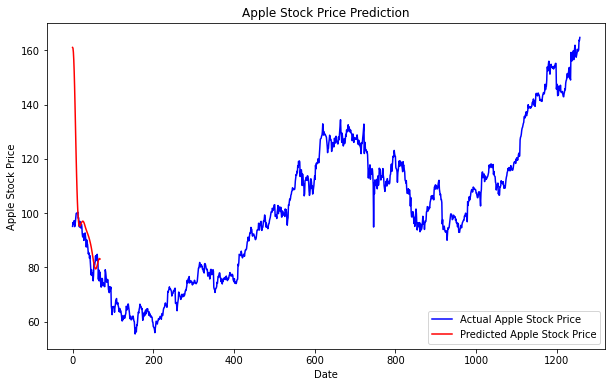

In [61]:
plt.figure(figsize=(10,6))  
plt.plot(test_stock_data_processed, color='blue', label='Actual Apple Stock Price')  
plt.plot(predicted_stock_price , color='red', label='Predicted Apple Stock Price')  
plt.title('Apple Stock Price Prediction')  
plt.xlabel('Date')  
plt.ylabel('Apple Stock Price')  
plt.legend()  
plt.show()  

In [63]:
#inputs = inputs.reshape(-1,1)
#inputs = sc.transform(inputs)


test_inputs = test_stock_data_processed.reshape(-1,1)
test_inputs = sc.transform(test_inputs)


print(test_inputs.shape)

(1258, 1)


In [64]:
test_features = []
for i in range(60, 291):
    test_features.append(test_inputs[i-60:i, 0])
    
test_features = np.array(test_features)

In [65]:
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))  
print(test_features.shape)

(231, 60, 1)


In [66]:
predicted_stock_price = model.predict(test_features)

8/8 [==============================] - 1s 73ms/step


In [67]:
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
print(predicted_stock_price.shape)

(231, 1)


In [68]:
print(test_stock_data_processed.shape)

(1258, 1)


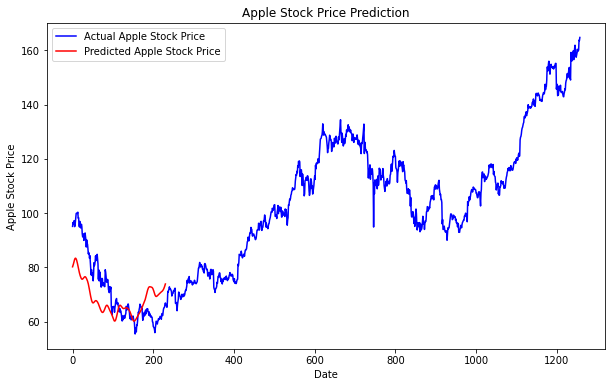

In [69]:
plt.figure(figsize=(10,6))  
plt.plot(test_stock_data_processed, color='blue', label='Actual Apple Stock Price')  
plt.plot(predicted_stock_price , color='red', label='Predicted Apple Stock Price')  
plt.title('Apple Stock Price Prediction')  
plt.xlabel('Date')  
plt.ylabel('Apple Stock Price')  
plt.legend()  
plt.show()  

## Download the model and the weights

In [ ]:
from google.colab import files

In [71]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)

In [ ]:
files.download("model.json")

In [ ]:
model.save('weights.h5')
files.download('weights.h5')